In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [2]:
import torch
import torch.backends.cudnn as cudnn
import random
import numpy as np

# seeds
seed = 88
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
cudnn.deterministic = True
cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
g = torch.Generator()
g.manual_seed(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [3]:
# import torchvision.datasets as datasets
# import torchvision.transforms as transforms
# import matplotlib.pyplot as plt
# from torch.utils.data import ConcatDataset

# # remove copyright banner
# class RemoveCopyrightBanner(object):
#     def __call__(self, img):
#         width, height = img.size
#         return img.crop((0, 0, width, height - 20))

# transform = transforms.Compose([
#     RemoveCopyrightBanner(),
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# granularity = 'variant'

# # # Create the FGVC Aircraft dataset instance
# # train_dataset = FGVCAircraft(
# #     root='./data',
# #     split='trainval',              # Options: 'train', 'val', 'trainval', 'test'
# #     annotation_level=granularity,    # Options: 'variant', 'family', 'manufacturer'
# #     transform=transform,
# #     download=True
# # )

# data_root = './data'

# train_dataset = datasets.FGVCAircraft(
#     root=data_root,
#     split='train',
#     annotation_level=granularity,
#     download=True,
#     transform=transform
# )

# val_dataset = datasets.FGVCAircraft(
#     root=data_root,
#     split='val',
#     annotation_level=granularity,
#     download=True,
#     transform=transform
# )
# test_dataset = datasets.FGVCAircraft(
#     root=data_root,
#     split='test',
#     annotation_level=granularity,
#     download=True,
#     transform=transform
# )

# trainval_dataset = ConcatDataset([train_dataset, val_dataset])
# train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [0.8, 0.2], generator=g)

# # val_dataset = FGVCAircraft(
# #     root='./data',
# #     split='val',
# #     annotation_level='variant',
# #     transform=transform,
# #     download=True
# # )

# # test_dataset = FGVCAircraft(
# #     root='./data',
# #     split='test',
# #     annotation_level=granularity,
# #     transform=transform,
# #     download=True
# # )

In [8]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset

# remove copyright banner
class RemoveCopyrightBanner(object):
    def __call__(self, img):
        width, height = img.size
        return img.crop((0, 0, width, height - 20))

transform = transforms.Compose([
    RemoveCopyrightBanner(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# granularity = 'variant'

# # Create the FGVC Aircraft dataset instance
# train_dataset = FGVCAircraft(
#     root='./data',
#     split='trainval',              # Options: 'train', 'val', 'trainval', 'test'
#     annotation_level=granularity,    # Options: 'variant', 'family', 'manufacturer'
#     transform=transform,
#     download=True
# )

data_root = './data'

train_dataset = datasets.DTD(
    root=data_root,
    split='train',
    download=True,
    transform=transform
)

val_dataset = datasets.DTD(
    root=data_root,
    split='val',
    download=True,
    transform=transform
)
test_dataset = datasets.DTD(
    root=data_root,
    split='test',
    download=True,
    transform=transform
)

trainval_dataset = ConcatDataset([train_dataset, val_dataset])
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [0.8, 0.2], generator=g)

# val_dataset = FGVCAircraft(
#     root='./data',
#     split='val',
#     annotation_level='variant',
#     transform=transform,
#     download=True
# )

# test_dataset = FGVCAircraft(
#     root='./data',
#     split='test',
#     annotation_level=granularity,
#     transform=transform,
#     download=True
# )

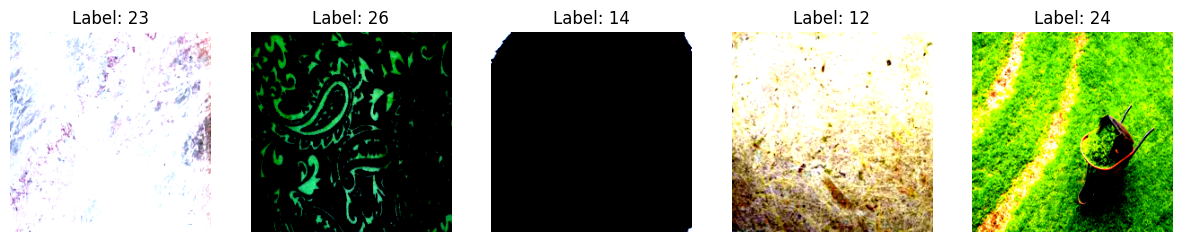

In [9]:
# function to show images
def show_images(train_dataset, num_images=5):
  #shuffle the dataset
  train_dataset = torch.utils.data.Subset(train_dataset, torch.randperm(len(train_dataset)))
  fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
  for i in range(num_images):
      image, label = train_dataset[i]
      image = image.permute(1, 2, 0)  # convert from CxHxW to HxWxC
      axes[i].imshow(image)
      axes[i].set_title(f'Label: {label}')
      axes[i].axis('off')
  plt.show()

show_images(train_dataset, num_images=5)

# Create Dataset

In [10]:
from collections import defaultdict
import torch
from tqdm import tqdm

def group_task_indices(dataset, cumulative=False, max_per_class=1000, classes_per_task=10):
    """
    Task 0: 0-9, Task 1: 10-19, ..., Task 9: 90-99
    Output a dictionary where keys are task indices and values are lists of image indices.
    For example, task_dict[0] will contain indices of images with labels 0-9.
    """
    per_class_counts = defaultdict(int)
    task_dict = defaultdict(list)
    for idx, (_, label) in tqdm(enumerate(dataset), total=len(dataset)):
        # for test and val, should have cumulative indices (all classes seen so far)
        if per_class_counts[label] >= max_per_class:
          continue
        per_class_counts[label] += 1
        if cumulative:
          for i in range((label // classes_per_task), classes_per_task):
            task_dict[i].append(idx)
        else:
          task_dict[label // classes_per_task].append(idx)
    return task_dict

train_task_idxs = group_task_indices(train_dataset, cumulative=False, max_per_class=60)
val_task_idxs = group_task_indices(val_dataset, cumulative=True)
test_task_idxs = group_task_indices(test_dataset, cumulative=True)

100%|██████████| 1880/1880 [00:08<00:00, 209.13it/s]


In [11]:
labels_dict = defaultdict(int)
for i in tqdm(train_task_idxs[0], total=len(train_task_idxs)):
    _, label = train_dataset[i]
    labels_dict[label] += 1
print(labels_dict)

print(f'Total number of tasks: {len(train_task_idxs)}')

599it [00:03, 184.47it/s]

defaultdict(<class 'int'>, {0: 60, 5: 60, 3: 60, 2: 60, 7: 60, 4: 60, 1: 60, 6: 59, 8: 60, 9: 60})
Total number of tasks: 5


## Training Code

In [12]:
def val_net(net_to_val, val_loader):
    net_to_val.eval()
    loss = 0

    criterion = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for img, label in tqdm(val_loader, desc="Validating"):

            # Get the input images and their corresponding labels
            img, label = img.cuda(), label.cuda()

            # Forward pass: Get predictions from the model
            outputs = net_to_val(img)

            # compute SmoothL1Losss
            loss += criterion(outputs, label)

        return loss / len(val_loader)

def train_net(max_epochs, freeze_epochs, patience, net_to_train, opt, train_loader, val_loader, task, save_file=None, save_path=None):
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    # prepare the net for training
    net_to_train.cuda()

    # freeze backbone
    for param in net_to_train.parameters():
        param.requires_grad = False
    for param in net_to_train.fc.parameters():
        param.requires_grad = True

    # loop over the dataset multiple times
    for epoch in range(max_epochs):
        net_to_train.train()

        running_loss = 0.0

        # unfreeze all layers
        if epoch == freeze_epochs:
          for param in net_to_train.parameters():
              param.requires_grad = True
              # change optimizer learning rate
              opt.param_groups[0]['lr'] = 1e-4

        # train on batches of data
        for imgs, labels in tqdm(train_loader, unit='batch'):

            imgs, labels = imgs.cuda(), labels.cuda()

            # zero the parameter gradients
            opt.zero_grad()

            # prediction
            outputs = net_to_train(imgs)

            # compute the loss
            loss = criterion(outputs, labels)
            loss.backward()
            opt.step()

            # print loss statistics
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        val_losses.append(val_net(net_to_train, val_loader))
        print(f"Epoch {epoch + 1}, Training Loss: {avg_loss:.3f}, Validation Loss: {val_losses[-1]:.3f}")

        # save to checkpoint
        if save_path:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': net_to_train.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'loss': avg_loss,
            }, save_path)
            print(f"Checkpoint saved to {save_path}")

        # save task, trainloss, valloss to file
        if save_file:
            with open(save_file, 'a') as f:
                f.write(f"{task},{epoch + 1},{avg_loss},{val_losses[-1]}\n")

        # early stopping based on patience
        if len(val_losses) > patience and val_losses[-1] >= min(val_losses[:-patience]):
            print(f"Early stopping at epoch {epoch + 1}")
            break

    print("finished training")
    return train_losses, val_losses

In [13]:
import torch.nn as nn
def modify_resnet_head(model, num_classes):
  """
  Modify the last fully connected layer of the ResNet model to match the number of classes.
  """

  old_fc = model.fc
  old_num_classes = old_fc.out_features
  num_ftrs = old_fc.in_features

  # Create the new head
  new_fc = nn.Linear(num_ftrs, num_classes).cuda()

  # Copy weights and biases from the old head
  if old_num_classes < num_classes:
    new_fc.weight.data[:old_num_classes, :] = old_fc.weight.data.clone().cuda()
    new_fc.bias.data[:old_num_classes] = old_fc.bias.data.clone().cuda()

  model.fc = new_fc
  return model

In [14]:
import torch

def get_test_accuracy(model, test_loader, num_classes):
    model.eval()
    correct_preds = 0
    total = 0
    correct_per_class = [0] * num_classes
    total_per_class = [0] * num_classes

    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="Testing", total=len(test_loader)):
            imgs, labels = imgs.cuda(), labels.cuda()
            output = model(imgs)
            preds = output.argmax(dim=1)

            correct_preds += (preds == labels).sum().item()
            total += labels.size(0)

            # Per-class stats
            for c in range(num_classes):
                correct_per_class[c] += ((preds == c) & (labels == c)).sum().item()
                total_per_class[c] += (labels == c).sum().item()

    overall_acc = correct_preds / total
    per_class_acc = [correct_per_class[c] / total_per_class[c] if total_per_class[c] > 0 else 0.0
                     for c in range(num_classes)]
    return overall_acc, per_class_acc


In [ ]:
from torch.utils.data import Subset
from torchvision import models
import torch.optim as optim

# Initialize the model
model = models.resnet18(pretrained=True)

# freeze all parameters except the last fc layer
for name, param in model.named_parameters():
    if name != 'fc.weight' and name != 'fc.bias':
        param.requires_grad = False

# test_loader = torch.utils.data.DataLoader(
#     test_dataset, batch_size=32, shuffle=False, num_workers=4, worker_init_fn=seed_worker, generator=g
# )

# create output file for train and val losses

save_dir = 'naive'

for task in range(10):

    print(f"Training on task {task}...")

    model = modify_resnet_head(model, (task+1) * 10)
    model = model.cuda()

    optimizer = optim.Adam(model.parameters(), lr=0.0015)

    train_loader = torch.utils.data.DataLoader(
        Subset(train_dataset, train_task_idxs[task]), batch_size=64, shuffle=True, num_workers=4, worker_init_fn=seed_worker, generator=g
    )
    val_loader = torch.utils.data.DataLoader(
        Subset(val_dataset, val_task_idxs[task]), batch_size=64, shuffle=False, num_workers=4, worker_init_fn=seed_worker, generator=g
    )

    test_loader = torch.utils.data.DataLoader(
        Subset(test_dataset, test_task_idxs[task]), batch_size=64, shuffle=False, num_workers=4, worker_init_fn=seed_worker, generator=g
    )

    # create output file for train and val losses
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Train the model on the current task
    train_losses, val_losses = train_net(15, 5, 8, model, optimizer, train_loader, val_loader, task, save_file=os.path.join(save_dir, 'train_val_losses.txt'))

    # Evaluate the model on the test set
    overall_acc, per_class_acc = get_test_accuracy(model, test_loader, (task+1) * 10)
    print(f"Overall accuracy for task {task}: {overall_acc:.4f}")
    print(f"Per-class accuracy for task {task}: {per_class_acc}")

    # save to text file in save dir
    if not os.path.exists(os.path.join(save_dir, 'accuracies.txt')):
        with open(os.path.join(save_dir, 'accuracies.txt'), 'w') as f:
            f.write("Task,Overall Accuracy,Per-Class Accuracy\n")
    with open(os.path.join(save_dir, 'accuracies.txt'), 'a') as f:
        f.write(f"{task},{overall_acc:.4f},{per_class_acc}\n")

    # Save the model after training on each task in save dir
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    torch.save(model.state_dict(), os.path.join(save_dir, f"model_task_{task}.pth"))
    print(f"Model for task {task} saved as model_task_{task}.pth")

In [ ]:
# zip the naive folder
import shutil
shutil.make_archive('naive', 'zip', 'naive')

'/content/naive.zip'

## Replay Code

In [ ]:
def train_net(max_epochs, freeze_epochs, patience, net_to_train, opt, train_loader, val_loader, task, save_file=None, save_path=None):
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    net_to_train.cuda()

    initial_freeze = (task == 0) # Only freeze initially for the very first task

    for name, param in net_to_train.named_parameters():
        # do not train non-fc layers
        if initial_freeze and 'fc' not in name:
            param.requires_grad = False
        else:
            param.requires_grad = True

    optimizer = opt

    best_val_loss = float('inf')
    epochs_no_improve = 0

    print(f"Starting training for Task {task}. Trainable parameters:")
    for name, param in net_to_train.named_parameters():
        if param.requires_grad:
             print(f"  - {name}")


    for epoch in range(max_epochs):
        net_to_train.train()
        running_loss = 0.0

        # Unfreeze logic (if desired for staged training within a task)
        if epoch == freeze_epochs and task > 0: # Only unfreeze/adjust LR if NOT task 0 and freeze_epochs > 0
            print(f"Unfreezing backbone at epoch {epoch} for task {task}")
            for param in net_to_train.parameters():
                param.requires_grad = True
            # Adjust LR for the existing optimizer
            current_lr = optimizer.param_groups[0]['lr']
            new_lr = 1e-4 # Or some other value
            if current_lr != new_lr:
                 print(f"Setting LR to {new_lr}")
                 for g in optimizer.param_groups:
                     g['lr'] = new_lr


        for imgs, labels in tqdm(train_loader, unit='batch', desc=f"Task {task} Epoch {epoch+1}"):
            imgs, labels = imgs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = net_to_train(imgs)
            loss = criterion(outputs, labels) # Loss calculated on combined batch
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        # --- Validation (Use Cumulative Loader!) ---
        current_val_loss = val_net(net_to_train, val_loader) # val_loader MUST be cumulative
        val_losses.append(current_val_loss)

        print(f"Task {task}, Epoch {epoch + 1}, Train Loss: {avg_loss:.4f}, Val Loss (Cumulative): {current_val_loss:.4f}")

        # --- Logging to file ---
        if save_file:
             with open(save_file, 'a') as f:
                  f.write(f"{task},{epoch + 1},{avg_loss},{current_val_loss}\n") # Log cumulative val loss

        # --- Early Stopping (Based on CUMULATIVE validation loss) ---
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            epochs_no_improve = 0
            if save_path: # Optional: save best model state
               torch.save(net_to_train.state_dict(), os.path.join(save_path, f"model_task{task}_best.pth"))
               print(f"  New best validation loss: {best_val_loss:.4f}. Saved best model.")
        else:
            epochs_no_improve += 1
            # print(f"  Validation loss did not improve for {epochs_no_improve} epoch(s). Best: {best_val_loss:.4f}") # Optional verbose print

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1} for task {task}. Best Val Loss: {best_val_loss:.4f}")
            if save_path and os.path.exists(os.path.join(save_path, f"model_task{task}_best.pth")):
               print("Loading best model weights before exiting.")
               net_to_train.load_state_dict(torch.load(os.path.join(save_path, f"model_task{task}_best.pth")))
            break

    print(f"Finished training task {task}")
    return train_losses, val_losses

In [ ]:
import random
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from torchvision import models
import torch.optim as optim


# Initialize the model
model = models.resnet18(pretrained=True)

# freeze all parameters except the last fc layer
for name, param in model.named_parameters():
    if name != 'fc.weight' and name != 'fc.bias':
        param.requires_grad = False

# --- Add outside the loop ---
memory_buffer = [] # Simple list to store (image_tensor, label) tuples
memory_size = 1000 # Max number of samples in buffer (hyperparameter)
samples_per_task_in_memory = 20 # How many samples to add from each task (hyperparameter)

def update_memory_buffer(buffer, max_size, new_samples):
    """Adds new samples to the buffer and trims it if it exceeds max_size."""
    buffer.extend(new_samples)
    # If buffer exceeds max size, remove samples randomly (or use FIFO)
    overflow = len(buffer) - max_size
    if overflow > 0:
        # Randomly remove 'overflow' samples
        indices_to_remove = random.sample(range(len(buffer)), overflow)
        # Remove in reverse sorted order to avoid index shifting issues
        for index in sorted(indices_to_remove, reverse=True):
            del buffer[index]
        # Alternatively, for FIFO: del buffer[:overflow]
    print(f"Memory buffer size: {len(buffer)} / {max_size}")

class MemoryDataset(Dataset):
    """A simple Dataset wrapper for the list-based memory buffer."""
    def __init__(self, buffer_list):
        self.buffer = buffer_list

    def __len__(self):
        return len(self.buffer)

    def __getitem__(self, idx):
        # buffer contains (image_tensor, label)
        return self.buffer[idx]

# --- Modify your main loop ---
save_dir = 'replay-coarse-grained' # Changed directory name

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
# Clear or initialize log files
open(os.path.join(save_dir, 'train_val_losses.txt'), 'w').close()
open(os.path.join(save_dir, 'accuracies.txt'), 'w').write("Task,Overall Accuracy,Per-Class Accuracy\n")


for task in range(5):
    print(f"Training on task {task}...")

    model = modify_resnet_head(model, (task+1) * 10)
    model = model.cuda()

    # --- Prepare Current Task Dataset ---
    current_task_train_subset = Subset(train_dataset, train_task_idxs[task])

    # --- Prepare Combined Training Loader ---
    if task > 0 and len(memory_buffer) > 0:
        # Create a dataset from the memory buffer
        replay_dataset = MemoryDataset(memory_buffer)
        # Combine current task data and replay data
        combined_train_dataset = ConcatDataset([current_task_train_subset, replay_dataset])
        print(f"Task {task}: Training with {len(current_task_train_subset)} current samples and {len(replay_dataset)} replay samples.")
    else:
        # Task 0 or empty buffer: train only on current task data
        combined_train_dataset = current_task_train_subset
        print(f"Task {task}: Training only with {len(current_task_train_subset)} current samples.")

    # Create DataLoader for the combined dataset
    # Adjust batch size if needed, maybe smaller if memory is large
    train_loader_combined = DataLoader(
        combined_train_dataset,
        batch_size=128, # Or adjust dynamically
        shuffle=True,
        num_workers=4,
        worker_init_fn=seed_worker,
        generator=g
    )

    # --- Validation and Test Loaders (Should still be CUMULATIVE!) ---
    val_loader_cumulative = torch.utils.data.DataLoader(
        Subset(val_dataset, val_task_idxs[task]),
        batch_size=256,
        shuffle=False,
        num_workers=4,
        worker_init_fn=seed_worker,
        generator=g
    )

    test_loader_cumulative = torch.utils.data.DataLoader(
        Subset(test_dataset, test_task_idxs[task]),
        batch_size=256,
        shuffle=False,
        num_workers=4,
        worker_init_fn=seed_worker,
        generator=g
    )

    # --- Optimizer ---
    # Consider re-initializing or adjusting LR, especially after task 0
    if task == 0:
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0015)
    else:
        optimizer = optim.Adam(model.parameters(), lr=1e-4) # Lower LR for full network


    # --- Train the model ---
    # train_net now uses the combined loader
    # No need for EWC parameters here
    train_losses, val_losses = train_net(
        max_epochs=15,
        freeze_epochs=5, # Still relevant if you want staged training
        patience=5,
        net_to_train=model,
        opt=optimizer,
        train_loader=train_loader_combined, # Use the combined loader
        val_loader=val_loader_cumulative, # Use the CUMULATIVE validation loader
        task=task,
        save_file=os.path.join(save_dir, 'train_val_losses.txt')
    )

    # --- Update Memory Buffer AFTER training ---
    # Select samples from the task just finished
    num_to_sample = min(samples_per_task_in_memory, len(current_task_train_subset))
    if num_to_sample > 0:
        indices_to_sample = random.sample(range(len(current_task_train_subset)), num_to_sample)
        new_memory_samples = []
        print(f"Sampling {num_to_sample} examples from task {task} for memory buffer...")
        for idx in indices_to_sample:
            # Get the actual data point (image tensor, label) from the subset
            img_tensor, label = current_task_train_subset[idx]
            new_memory_samples.append((img_tensor, label)) # Append as tuple

        # Add to buffer and manage size
        update_memory_buffer(memory_buffer, memory_size, new_memory_samples)
    else:
        print(f"Not enough samples in task {task} subset to add to memory.")


    # --- Evaluate and Save ---
    overall_acc, per_class_acc = get_test_accuracy(model, test_loader_cumulative, (task+1) * 10)
    print(f"Overall accuracy for task {task} (on classes 0-{(task+1)*10 - 1}): {overall_acc:.4f}")

    with open(os.path.join(save_dir, 'accuracies.txt'), 'a') as f:
        f.write(f"{task},{overall_acc:.4f},{per_class_acc}\n")

    torch.save(model.state_dict(), os.path.join(save_dir, f"model_task_{task}.pth"))
    print(f"Model for task {task} saved as model_task_{task}.pth")

In [ ]:
import shutil
shutil.make_archive('replay-coarse-grained', 'zip', 'replay-coarse-grained')

'/content/replay-coardse-grained.zip'

# EWC + Replay Code

In [15]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import random

class EWC:
    def __init__(self, model, device='cuda', lambda_ewc=5000):
        """
        Initialize the Robust EWC class with a model and hyperparameters.

        Args:
            model: The neural network model
            device: Device to perform computations on ('cuda' or 'cpu')
            lambda_ewc: Regularization strength for EWC penalty
        """
        self.model = model
        self.device = device
        self.lambda_ewc = lambda_ewc

        # Dictionary to store Fisher information for each task
        self.fisher_dict = {}
        # Dictionary to store optimal parameters for each task
        self.optpar_dict = {}
        # Dictionary to store output layer sizes for each task
        self.output_sizes = {}
        # Dictionary to track important parameters
        self.important_params = {}

    def compute_fisher(self, data_loader, samples=500):
        """
        Compute the diagonal Fisher Information Matrix with proper sampling and verification.

        Args:
            data_loader: DataLoader containing the task's data
            samples: Number of samples to use for Fisher computation

        Returns:
            Dictionary with parameter names as keys and Fisher values as values
        """
        fisher = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
        self.model.eval()

        sample_loader = torch.utils.data.DataLoader(
            torch.utils.data.Subset(data_loader.dataset,
                                  torch.randperm(len(data_loader.dataset))[:samples].tolist()),
            batch_size=1, shuffle=True
        )

        for input_data, _ in sample_loader:
            input_data = input_data.to(self.device)
            output = self.model(input_data)
            probs = F.softmax(output, dim=1)

            num_classes = probs.size(1)
            for c in range(num_classes):
                self.model.zero_grad()
                class_prob = probs[0, c]
                log_class_prob = torch.log(class_prob)
                log_class_prob.backward(retain_graph=(c < num_classes-1))

                prob_value = class_prob.item()
                for n, p in self.model.named_parameters():
                    if p.grad is not None and p.requires_grad:
                        fisher[n] += prob_value * p.grad.data.pow(2) / samples

        return fisher

    def store_task_parameters(self, task_id, data_loader):
        """
        Store the optimal parameters and compute Fisher after training on a task.

        Args:
            task_id: ID of the current task
            data_loader: DataLoader for the current task
        """
        print(f"Storing parameters for task {task_id}...")

        # Store current parameter values
        self.optpar_dict[task_id] = {}
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                self.optpar_dict[task_id][n] = p.data.clone()
                # Debug: Print parameter statistics for key layers
                if 'fc' in n or 'layer4' in n:
                    print(f"Stored parameter {n}: min={p.min().item():.6f}, max={p.max().item():.6f}, mean={p.mean().item():.6f}")

        # Compute and store Fisher Information Matrix
        self.fisher_dict[task_id] = self.compute_fisher(data_loader)

        # Store output layer size for this task
        if hasattr(self.model, 'fc'):
            self.output_sizes[task_id] = self.model.fc.weight.size(0)
            print(f"Stored output size for task {task_id}: {self.output_sizes[task_id]}")
        elif hasattr(self.model, 'classifier'):
            self.output_sizes[task_id] = self.model.classifier.weight.size(0)
            print(f"Stored output size for task {task_id}: {self.output_sizes[task_id]}")

    def ewc_loss(self, current_task_id):
        """
        Calculate the EWC penalty with importance scaling and verification.

        Args:
            current_task_id: ID of the current task

        Returns:
            EWC penalty loss
        """
        if current_task_id == 0:
            return torch.tensor(0.0, device=self.device)

        total_loss = 0
        param_count = 0

        # Calculate EWC loss for all previous tasks
        for task_id in range(current_task_id):
            task_loss = 0

            for n, p in self.model.named_parameters():
                if p.requires_grad and n in self.fisher_dict[task_id] and n in self.optpar_dict[task_id]:
                    # Handle expanding output layer
                    if "fc.weight" in n:
                        prev_size = self.output_sizes[task_id]
                        fisher_term = self.fisher_dict[task_id][n][:prev_size, :]
                        param_diff = (p[:prev_size, :] - self.optpar_dict[task_id][n][:prev_size, :]).pow(2)
                        task_loss += (fisher_term * param_diff).sum()
                        param_count += fisher_term.numel()
                    elif "fc.bias" in n:
                        prev_size = self.output_sizes[task_id]
                        fisher_term = self.fisher_dict[task_id][n][:prev_size]
                        param_diff = (p[:prev_size] - self.optpar_dict[task_id][n][:prev_size]).pow(2)
                        task_loss += (fisher_term * param_diff).sum()
                        param_count += fisher_term.numel()
                    else:
                        fisher_term = self.fisher_dict[task_id][n]
                        param_diff = (p - self.optpar_dict[task_id][n]).pow(2)
                        task_loss += (fisher_term * param_diff).sum()
                        param_count += fisher_term.numel()

            total_loss += task_loss

        # Apply lambda scaling
        ewc_penalty = self.lambda_ewc * total_loss / 2

        # Verify EWC penalty is significant enough (only in training mode to avoid spam)
        if self.model.training:
            with torch.no_grad():
                avg_penalty = ewc_penalty.item() / param_count if param_count > 0 else 0
                if avg_penalty < 1e-4:
                    print(f"WARNING: Average EWC penalty per parameter is very small: {avg_penalty:.8f}")

        return ewc_penalty

    def freeze_important_parameters(self, current_task_id, importance_threshold=0.1):
        """
        Freeze parameters that are most important for previous tasks.

        Args:
            current_task_id: ID of the current task
            importance_threshold: Threshold for determining important parameters
        """
        if current_task_id == 0:
            return

        # Calculate importance for each parameter based on Fisher
        importance = {}
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                importance[n] = 0
                for task_id in range(current_task_id):
                    if n in self.fisher_dict[task_id]:
                        # For expanding layers, only consider the relevant part
                        if "fc.weight" in n or "fc.bias" in n:
                            prev_size = self.output_sizes[task_id]
                            if "fc.weight" in n:
                                importance[n] += self.fisher_dict[task_id][n][:prev_size, :].mean().item()
                            else:  # fc.bias
                                importance[n] += self.fisher_dict[task_id][n][:prev_size].mean().item()
                        else:
                            importance[n] += self.fisher_dict[task_id][n].mean().item()

                # Average across tasks
                importance[n] /= current_task_id

        # Sort parameters by importance
        sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

        # Determine threshold value
        if importance_threshold < 1:  # Interpreted as a fraction
            threshold_idx = int(len(sorted_importance) * importance_threshold)
            threshold_value = sorted_importance[threshold_idx][1] if threshold_idx < len(sorted_importance) else 0
        else:  # Interpreted as an absolute value
            threshold_value = importance_threshold

        # Freeze important parameters
        frozen_count = 0
        self.important_params = {}
        for n, imp in sorted_importance:
            if imp > threshold_value:
                for name, param in self.model.named_parameters():
                    if name == n:
                        param.requires_grad = False
                        self.important_params[name] = imp
                        frozen_count += 1
                        break

        print(f"Froze {frozen_count} important parameters with importance > {threshold_value:.6f}")

    def consolidate_weights(self):
        """
        Consolidate weights after training on a task by averaging with previous optimal weights
        weighted by their importance.
        """
        if not self.optpar_dict:  # No previous tasks
            return

        print("Consolidating weights based on importance...")

        # Get the most recent task_id
        last_task_id = max(self.optpar_dict.keys())

        with torch.no_grad():
            for n, p in self.model.named_parameters():
                if n in self.important_params and n in self.optpar_dict[last_task_id]:
                    # Calculate importance-weighted average of current weights and previous optimal weights
                    importance = self.important_params[n]
                    if importance > 0.1:  # Only consolidate highly important parameters
                        weight_factor = min(0.8, importance)  # Cap at 0.8 to allow some adaptation
                        consolidated_weight = (
                            weight_factor * self.optpar_dict[last_task_id][n] +
                            (1 - weight_factor) * p.data
                        )
                        p.data.copy_(consolidated_weight)
                        print(f"Consolidated parameter {n} with weight factor {weight_factor:.4f}")

In [16]:
def train_net_ewc_replay(max_epochs, freeze_epochs, patience, ewc, net_to_train, opt, train_loader, val_loader, task, save_file=None, save_path=None):
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    net_to_train.cuda()

    initial_freeze = (task == 0) # Only freeze initially for the very first task

    # if task > 0:
    #     ewc.freeze_important_parameters(task, importance_threshold=0.05)

    for name, param in net_to_train.named_parameters():
        # do not train non-fc layers
        if initial_freeze and 'fc' not in name:
            param.requires_grad = False
        else:
            param.requires_grad = True

    optimizer = opt

    best_val_loss = float('inf')
    epochs_no_improve = 0

    print(f"Starting training for Task {task}. Trainable parameters:")
    for name, param in net_to_train.named_parameters():
        if param.requires_grad:
             print(f"  - {name}")


    for epoch in range(max_epochs):
        net_to_train.train()
        running_loss = 0.0
        running_ewc = 0.0

        # Unfreeze logic (if desired for staged training within a task)
        if epoch == freeze_epochs and task > 0: # Only unfreeze/adjust LR if NOT task 0 and freeze_epochs > 0
            print(f"Unfreezing backbone at epoch {epoch} for task {task}")
            for name, param in net_to_train.named_parameters():
                if not param.requires_grad and 'fc' not in name:
                    # Check if this parameter was frozen by importance
                    was_frozen_by_importance = False
                    for n, imp in getattr(ewc, 'important_params', {}).items():
                        if n == name:
                            was_frozen_by_importance = True
                            break

                    if not was_frozen_by_importance:
                        param.requires_grad = True

            # Adjust LR for the existing optimizer
            current_lr = optimizer.param_groups[0]['lr']
            new_lr = 1e-4 # Or some other value
            if current_lr != new_lr:
                 print(f"Setting LR to {new_lr}")
                 for g in optimizer.param_groups:
                     g['lr'] = new_lr


        for imgs, labels in tqdm(train_loader, unit='batch', desc=f"Task {task} Epoch {epoch+1}"):
            imgs, labels = imgs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = net_to_train(imgs)
            loss = criterion(outputs, labels) # Loss calculated on combined batch
            ewc_loss = ewc.ewc_loss(task)
            running_ewc += ewc_loss.item()
            loss += ewc_loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net_to_train.parameters(), max_norm=1.0) # Gradient clipping
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        avg_ewc_loss = running_ewc / len(train_loader)
        train_losses.append(avg_loss)

        # --- Validation (Use Cumulative Loader!) ---
        current_val_loss = val_net(net_to_train, val_loader) # val_loader MUST be cumulative
        val_losses.append(current_val_loss)

        print(f"Task {task}, Epoch {epoch + 1}, EWC Loss: {avg_ewc_loss:.4f}, Total Loss: {avg_loss:.4f}, Val Loss (Cumulative): {current_val_loss:.4f}")

        # --- Logging to file ---
        if save_file:
             with open(save_file, 'a') as f:
                  f.write(f"{task},{epoch + 1},{avg_loss},{current_val_loss}\n") # Log cumulative val loss

        # --- Early Stopping (Based on CUMULATIVE validation loss) ---
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            epochs_no_improve = 0
            if save_path: # Optional: save best model state
               torch.save(net_to_train.state_dict(), os.path.join(save_path, f"model_task{task}_best.pth"))
               print(f"  New best validation loss: {best_val_loss:.4f}. Saved best model.")
        else:
            epochs_no_improve += 1
            # print(f"  Validation loss did not improve for {epochs_no_improve} epoch(s). Best: {best_val_loss:.4f}") # Optional verbose print

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1} for task {task}. Best Val Loss: {best_val_loss:.4f}")
            if save_path and os.path.exists(os.path.join(save_path, f"model_task{task}_best.pth")):
               print("Loading best model weights before exiting.")
               net_to_train.load_state_dict(torch.load(os.path.join(save_path, f"model_task{task}_best.pth")))
            break

    print(f"Finished training task {task}")
    return train_losses, val_losses

In [17]:
import random
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from torchvision import models
import torch.optim as optim

LAMBDA_EWC = 10e5
save_dir = 'replay-ewc-coarse-grained-1M' # Changed directory name

# Initialize the model
model = models.resnet18(pretrained=True)
ewc = EWC(model, device='cuda', lambda_ewc=LAMBDA_EWC)

# freeze all parameters except the last fc layer
for name, param in model.named_parameters():
    if name != 'fc.weight' and name != 'fc.bias':
        param.requires_grad = False

# --- Add outside the loop ---
memory_buffer = [] # Simple list to store (image_tensor, label) tuples
memory_size = 1000 # Max number of samples in buffer (hyperparameter)
samples_per_task_in_memory = 20 # How many samples to add from each task (hyperparameter)

def update_memory_buffer(buffer, max_size, new_samples):
    """Adds new samples to the buffer and trims it if it exceeds max_size."""
    buffer.extend(new_samples)
    # If buffer exceeds max size, remove samples randomly (or use FIFO)
    overflow = len(buffer) - max_size
    if overflow > 0:
        # Randomly remove 'overflow' samples
        indices_to_remove = random.sample(range(len(buffer)), overflow)
        # Remove in reverse sorted order to avoid index shifting issues
        for index in sorted(indices_to_remove, reverse=True):
            del buffer[index]
        # Alternatively, for FIFO: del buffer[:overflow]
    print(f"Memory buffer size: {len(buffer)} / {max_size}")

class MemoryDataset(Dataset):
    """A simple Dataset wrapper for the list-based memory buffer."""
    def __init__(self, buffer_list):
        self.buffer = buffer_list

    def __len__(self):
        return len(self.buffer)

    def __getitem__(self, idx):
        # buffer contains (image_tensor, label)
        return self.buffer[idx]

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
# Clear or initialize log files
open(os.path.join(save_dir, 'train_val_losses.txt'), 'w').close()
open(os.path.join(save_dir, 'accuracies.txt'), 'w').write("Task,Overall Accuracy,Per-Class Accuracy\n")


for task in range(5):
    print(f"Training on task {task}...")

    model = modify_resnet_head(model, (task+1) * 10)
    model = model.cuda()

    # --- Prepare Current Task Dataset ---
    current_task_train_subset = Subset(train_dataset, train_task_idxs[task])

    # --- Prepare Combined Training Loader ---
    if task > 0 and len(memory_buffer) > 0:
        # Create a dataset from the memory buffer
        replay_dataset = MemoryDataset(memory_buffer)
        # Combine current task data and replay data
        combined_train_dataset = ConcatDataset([current_task_train_subset, replay_dataset])
        print(f"Task {task}: Training with {len(current_task_train_subset)} current samples and {len(replay_dataset)} replay samples.")
    else:
        # Task 0 or empty buffer: train only on current task data
        combined_train_dataset = current_task_train_subset
        print(f"Task {task}: Training only with {len(current_task_train_subset)} current samples.")

    # Create DataLoader for the combined dataset
    # Adjust batch size if needed, maybe smaller if memory is large
    train_loader_combined = DataLoader(
        combined_train_dataset,
        batch_size=128, # Or adjust dynamically
        shuffle=True,
        num_workers=4,
        worker_init_fn=seed_worker,
        generator=g
    )

    train_loader_not_combined = DataLoader(
        current_task_train_subset,
        batch_size=128,
        shuffle=True,
        num_workers=4,
        worker_init_fn=seed_worker,
        generator=g
    )

    # --- Validation and Test Loaders (Should still be CUMULATIVE!) ---
    val_loader_cumulative = torch.utils.data.DataLoader(
        Subset(val_dataset, val_task_idxs[task]),
        batch_size=256,
        shuffle=False,
        num_workers=4,
        worker_init_fn=seed_worker,
        generator=g
    )

    test_loader_cumulative = torch.utils.data.DataLoader(
        Subset(test_dataset, test_task_idxs[task]),
        batch_size=256,
        shuffle=False,
        num_workers=4,
        worker_init_fn=seed_worker,
        generator=g
    )

    # --- Optimizer ---
    # Consider re-initializing or adjusting LR, especially after task 0
    if task == 0:
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0015)
    else:
        optimizer = optim.Adam(model.parameters(), lr=1e-4) # Lower LR for full network


    # --- Train the model ---
    # train_net now uses the combined loader
    # No need for EWC parameters here
    train_losses, val_losses = train_net_ewc_replay(
        max_epochs=15,
        freeze_epochs=5, # Still relevant if you want staged training
        patience=5,
        ewc=ewc,
        net_to_train=model,
        opt=optimizer,
        train_loader=train_loader_combined, # Use the combined loader
        val_loader=val_loader_cumulative, # Use the CUMULATIVE validation loader
        task=task,
        save_file=os.path.join(save_dir, 'train_val_losses.txt')
    )



    # --- Update EWC after training ---
    ewc.store_task_parameters(task, train_loader_not_combined)
    # ewc.consolidate_weights()

    # --- Update Memory Buffer AFTER training ---
    # Select samples from the task just finished
    num_to_sample = min(samples_per_task_in_memory, len(current_task_train_subset))
    if num_to_sample > 0:
        indices_to_sample = random.sample(range(len(current_task_train_subset)), num_to_sample)
        new_memory_samples = []
        print(f"Sampling {num_to_sample} examples from task {task} for memory buffer...")
        for idx in indices_to_sample:
            # Get the actual data point (image tensor, label) from the subset
            img_tensor, label = current_task_train_subset[idx]
            new_memory_samples.append((img_tensor, label)) # Append as tuple

        # Add to buffer and manage size
        update_memory_buffer(memory_buffer, memory_size, new_memory_samples)
    else:
        print(f"Not enough samples in task {task} subset to add to memory.")


    # --- Evaluate and Save ---
    overall_acc, per_class_acc = get_test_accuracy(model, test_loader_cumulative, (task+1) * 10)
    print(f"Overall accuracy for task {task} (on classes 0-{(task+1)*10 - 1}): {overall_acc:.4f}")

    with open(os.path.join(save_dir, 'accuracies.txt'), 'a') as f:
        f.write(f"{task},{overall_acc:.4f},{per_class_acc}\n")

    torch.save(model.state_dict(), os.path.join(save_dir, f"model_task_{task}.pth"))
    print(f"Model for task {task} saved as model_task_{task}.pth")

Training on task 0...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Task 0: Training only with 599 current samples.
Starting training for Task 0. Trainable parameters:
  - fc.weight
  - fc.bias


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Task 0, Epoch 1, EWC Loss: 0.0000, Total Loss: 2.4704, Val Loss (Cumulative): 2.0929


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Task 0, Epoch 2, EWC Loss: 0.0000, Total Loss: 1.8889, Val Loss (Cumulative): 1.6405


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Task 0, Epoch 3, EWC Loss: 0.0000, Total Loss: 1.4342, Val Loss (Cumulative): 1.3128


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


Task 0, Epoch 4, EWC Loss: 0.0000, Total Loss: 1.0967, Val Loss (Cumulative): 1.0978


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Task 0, Epoch 5, EWC Loss: 0.0000, Total Loss: 0.8715, Val Loss (Cumulative): 0.9281


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Task 0, Epoch 6, EWC Loss: 0.0000, Total Loss: 0.7146, Val Loss (Cumulative): 0.8158


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Task 0, Epoch 7, EWC Loss: 0.0000, Total Loss: 0.6001, Val Loss (Cumulative): 0.7613


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Task 0, Epoch 8, EWC Loss: 0.0000, Total Loss: 0.5346, Val Loss (Cumulative): 0.7141


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Task 0, Epoch 9, EWC Loss: 0.0000, Total Loss: 0.4641, Val Loss (Cumulative): 0.6696


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Task 0, Epoch 10, EWC Loss: 0.0000, Total Loss: 0.4105, Val Loss (Cumulative): 0.6394


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Task 0, Epoch 11, EWC Loss: 0.0000, Total Loss: 0.3693, Val Loss (Cumulative): 0.6222


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Task 0, Epoch 12, EWC Loss: 0.0000, Total Loss: 0.3461, Val Loss (Cumulative): 0.6181


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Task 0, Epoch 13, EWC Loss: 0.0000, Total Loss: 0.3027, Val Loss (Cumulative): 0.5908


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Task 0, Epoch 14, EWC Loss: 0.0000, Total Loss: 0.2644, Val Loss (Cumulative): 0.5848


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Task 0, Epoch 15, EWC Loss: 0.0000, Total Loss: 0.2518, Val Loss (Cumulative): 0.5771
Finished training task 0
Storing parameters for task 0...
Stored parameter fc.weight: min=-0.124354, max=0.117243, mean=-0.004799
Stored parameter fc.bias: min=-0.055483, max=0.058792, mean=0.011413
Stored output size for task 0: 10
Sampling 20 examples from task 0 for memory buffer...
Memory buffer size: 20 / 1000


Testing: 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


Overall accuracy for task 0 (on classes 0-9): 0.8250
Model for task 0 saved as model_task_0.pth
Training on task 1...
Task 1: Training with 591 current samples and 20 replay samples.
Starting training for Task 1. Trainable parameters:
  - conv1.weight
  - bn1.weight
  - bn1.bias
  - layer1.0.conv1.weight
  - layer1.0.bn1.weight
  - layer1.0.bn1.bias
  - layer1.0.conv2.weight
  - layer1.0.bn2.weight
  - layer1.0.bn2.bias
  - layer1.1.conv1.weight
  - layer1.1.bn1.weight
  - layer1.1.bn1.bias
  - layer1.1.conv2.weight
  - layer1.1.bn2.weight
  - layer1.1.bn2.bias
  - layer2.0.conv1.weight
  - layer2.0.bn1.weight
  - layer2.0.bn1.bias
  - layer2.0.conv2.weight
  - layer2.0.bn2.weight
  - layer2.0.bn2.bias
  - layer2.0.downsample.0.weight
  - layer2.0.downsample.1.weight
  - layer2.0.downsample.1.bias
  - layer2.1.conv1.weight
  - layer2.1.bn1.weight
  - layer2.1.bn1.bias
  - layer2.1.conv2.weight
  - layer2.1.bn2.weight
  - layer2.1.bn2.bias
  - layer3.0.conv1.weight
  - layer3.0.bn1.weig

Task 1 Epoch 1:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 1 Epoch 1:  40%|████      | 2/5 [00:03<00:04,  1.43s/batch]

Task 1 Epoch 1:  60%|██████    | 3/5 [00:03<00:01,  1.02batch/s]

Task 1 Epoch 1:  80%|████████  | 4/5 [00:04<00:00,  1.30batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Task 1, Epoch 1, EWC Loss: 0.2979, Total Loss: 2.8190, Val Loss (Cumulative): 1.8571


Task 1 Epoch 2:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 1 Epoch 2:  20%|██        | 1/5 [00:02<00:11,  2.98s/batch]

Task 1 Epoch 2:  40%|████      | 2/5 [00:03<00:04,  1.51s/batch]

Task 1 Epoch 2:  60%|██████    | 3/5 [00:03<00:02,  1.03s/batch]

Task 1 Epoch 2:  80%|████████  | 4/5 [00:04<00:00,  1.24batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


Task 1, Epoch 2, EWC Loss: 0.1049, Total Loss: 1.5853, Val Loss (Cumulative): 1.6868


Task 1 Epoch 3:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 1 Epoch 3:  20%|██        | 1/5 [00:02<00:11,  2.81s/batch]

Task 1 Epoch 3:  40%|████      | 2/5 [00:03<00:04,  1.43s/batch]

Task 1 Epoch 3:  60%|██████    | 3/5 [00:03<00:01,  1.02batch/s]

Task 1 Epoch 3:  80%|████████  | 4/5 [00:04<00:00,  1.30batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


Task 1, Epoch 3, EWC Loss: 0.0446, Total Loss: 0.9949, Val Loss (Cumulative): 1.6002


Task 1 Epoch 4:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 1 Epoch 4:  20%|██        | 1/5 [00:03<00:15,  3.78s/batch]

Task 1 Epoch 4:  40%|████      | 2/5 [00:04<00:05,  1.85s/batch]

Task 1 Epoch 4:  60%|██████    | 3/5 [00:04<00:02,  1.21s/batch]

Task 1 Epoch 4:  80%|████████  | 4/5 [00:05<00:00,  1.10batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Task 1, Epoch 4, EWC Loss: 0.0235, Total Loss: 0.6276, Val Loss (Cumulative): 1.5561


Task 1 Epoch 5:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 1 Epoch 5:  20%|██        | 1/5 [00:02<00:11,  2.90s/batch]

Task 1 Epoch 5:  40%|████      | 2/5 [00:03<00:04,  1.46s/batch]

Task 1 Epoch 5:  60%|██████    | 3/5 [00:03<00:02,  1.00s/batch]

Task 1 Epoch 5:  80%|████████  | 4/5 [00:04<00:00,  1.28batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


Task 1, Epoch 5, EWC Loss: 0.0123, Total Loss: 0.3684, Val Loss (Cumulative): 1.5589
Unfreezing backbone at epoch 5 for task 1


Task 1 Epoch 6:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 1 Epoch 6:  20%|██        | 1/5 [00:03<00:14,  3.59s/batch]

Task 1 Epoch 6:  40%|████      | 2/5 [00:04<00:05,  1.75s/batch]

Task 1 Epoch 6:  60%|██████    | 3/5 [00:04<00:02,  1.15s/batch]

Task 1 Epoch 6:  80%|████████  | 4/5 [00:04<00:00,  1.14batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Task 1, Epoch 6, EWC Loss: 0.0066, Total Loss: 0.2202, Val Loss (Cumulative): 1.6167


Task 1 Epoch 7:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 1 Epoch 7:  20%|██        | 1/5 [00:02<00:11,  2.85s/batch]

Task 1 Epoch 7:  40%|████      | 2/5 [00:03<00:04,  1.44s/batch]

Task 1 Epoch 7:  60%|██████    | 3/5 [00:03<00:01,  1.01batch/s]

Task 1 Epoch 7:  80%|████████  | 4/5 [00:04<00:00,  1.29batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]


Task 1, Epoch 7, EWC Loss: 0.0038, Total Loss: 0.1044, Val Loss (Cumulative): 1.7038


Task 1 Epoch 8:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 1 Epoch 8:  20%|██        | 1/5 [00:02<00:10,  2.72s/batch]

Task 1 Epoch 8:  40%|████      | 2/5 [00:03<00:04,  1.39s/batch]

Task 1 Epoch 8:  60%|██████    | 3/5 [00:03<00:01,  1.04batch/s]

Task 1 Epoch 8:  80%|████████  | 4/5 [00:04<00:00,  1.32batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Task 1, Epoch 8, EWC Loss: 0.0023, Total Loss: 0.0539, Val Loss (Cumulative): 1.7606


Task 1 Epoch 9:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 1 Epoch 9:  20%|██        | 1/5 [00:02<00:10,  2.72s/batch]

Task 1 Epoch 9:  40%|████      | 2/5 [00:03<00:04,  1.42s/batch]

Task 1 Epoch 9:  60%|██████    | 3/5 [00:03<00:01,  1.02batch/s]

Task 1 Epoch 9:  80%|████████  | 4/5 [00:04<00:00,  1.28batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


Task 1, Epoch 9, EWC Loss: 0.0017, Total Loss: 0.0322, Val Loss (Cumulative): 1.7996
Early stopping triggered at epoch 9 for task 1. Best Val Loss: 1.5561
Finished training task 1
Storing parameters for task 1...
Stored parameter layer4.0.conv1.weight: min=-0.266234, max=0.383188, mean=-0.001589
Stored parameter layer4.0.bn1.weight: min=0.137776, max=0.428155, mean=0.264326
Stored parameter layer4.0.bn1.bias: min=-0.477460, max=0.147607, mean=-0.225677
Stored parameter layer4.0.conv2.weight: min=-0.284163, max=0.349329, mean=-0.001291
Stored parameter layer4.0.bn2.weight: min=0.141258, max=0.730531, mean=0.424485
Stored parameter layer4.0.bn2.bias: min=-0.400168, max=0.114137, mean=-0.197439
Stored parameter layer4.0.downsample.0.weight: min=-0.627720, max=0.747917, mean=-0.000853
Stored parameter layer4.0.downsample.1.weight: min=-0.051243, max=0.509745, mean=0.250658
Stored parameter layer4.0.downsample.1.bias: min=-0.400168, max=0.114137, mean=-0.197439
Stored parameter layer4.1.con

Testing: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Overall accuracy for task 1 (on classes 0-19): 0.5513
Model for task 1 saved as model_task_1.pth
Training on task 2...
Task 2: Training with 599 current samples and 40 replay samples.
Starting training for Task 2. Trainable parameters:
  - conv1.weight
  - bn1.weight
  - bn1.bias
  - layer1.0.conv1.weight
  - layer1.0.bn1.weight
  - layer1.0.bn1.bias
  - layer1.0.conv2.weight
  - layer1.0.bn2.weight
  - layer1.0.bn2.bias
  - layer1.1.conv1.weight
  - layer1.1.bn1.weight
  - layer1.1.bn1.bias
  - layer1.1.conv2.weight
  - layer1.1.bn2.weight
  - layer1.1.bn2.bias
  - layer2.0.conv1.weight
  - layer2.0.bn1.weight
  - layer2.0.bn1.bias
  - layer2.0.conv2.weight
  - layer2.0.bn2.weight
  - layer2.0.bn2.bias
  - layer2.0.downsample.0.weight
  - layer2.0.downsample.1.weight
  - layer2.0.downsample.1.bias
  - layer2.1.conv1.weight
  - layer2.1.bn1.weight
  - layer2.1.bn1.bias
  - layer2.1.conv2.weight
  - layer2.1.bn2.weight
  - layer2.1.bn2.bias
  - layer3.0.conv1.weight
  - layer3.0.bn1.wei

Task 2 Epoch 1:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 2 Epoch 1:  20%|██        | 1/5 [00:02<00:11,  2.78s/batch]

Task 2 Epoch 1:  40%|████      | 2/5 [00:03<00:04,  1.43s/batch]

Task 2 Epoch 1:  60%|██████    | 3/5 [00:03<00:01,  1.01batch/s]

Task 2 Epoch 1:  80%|████████  | 4/5 [00:04<00:00,  1.28batch/s]

Validating: 100%|██████████| 2/2 [00:03<00:00,  1.65s/it]


Task 2, Epoch 1, EWC Loss: 2.4649, Total Loss: 6.2234, Val Loss (Cumulative): 2.4083


Task 2 Epoch 2:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 2 Epoch 2:  20%|██        | 1/5 [00:03<00:12,  3.13s/batch]

Task 2 Epoch 2:  40%|████      | 2/5 [00:03<00:04,  1.57s/batch]

Task 2 Epoch 2:  60%|██████    | 3/5 [00:04<00:02,  1.07s/batch]

Task 2 Epoch 2:  80%|████████  | 4/5 [00:04<00:00,  1.21batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


Task 2, Epoch 2, EWC Loss: 2.3515, Total Loss: 5.1617, Val Loss (Cumulative): 2.3616


Task 2 Epoch 3:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 2 Epoch 3:  20%|██        | 1/5 [00:02<00:11,  2.87s/batch]

Task 2 Epoch 3:  40%|████      | 2/5 [00:03<00:04,  1.48s/batch]

Task 2 Epoch 3:  60%|██████    | 3/5 [00:03<00:02,  1.04s/batch]

Task 2 Epoch 3:  80%|████████  | 4/5 [00:04<00:00,  1.23batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]


Task 2, Epoch 3, EWC Loss: 1.4796, Total Loss: 4.1154, Val Loss (Cumulative): 2.3508


Task 2 Epoch 4:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 2 Epoch 4:  20%|██        | 1/5 [00:03<00:12,  3.00s/batch]

Task 2 Epoch 4:  40%|████      | 2/5 [00:03<00:04,  1.52s/batch]

Task 2 Epoch 4:  60%|██████    | 3/5 [00:03<00:02,  1.04s/batch]

Task 2 Epoch 4:  80%|████████  | 4/5 [00:04<00:00,  1.23batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


Task 2, Epoch 4, EWC Loss: 1.0923, Total Loss: 3.6475, Val Loss (Cumulative): 2.3256


Task 2 Epoch 5:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 2 Epoch 5:  20%|██        | 1/5 [00:03<00:15,  3.77s/batch]

Task 2 Epoch 5:  40%|████      | 2/5 [00:04<00:05,  1.84s/batch]

Task 2 Epoch 5:  60%|██████    | 3/5 [00:04<00:02,  1.22s/batch]

Task 2 Epoch 5:  80%|████████  | 4/5 [00:05<00:00,  1.08batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


Task 2, Epoch 5, EWC Loss: 0.9641, Total Loss: 3.3782, Val Loss (Cumulative): 2.2910
Unfreezing backbone at epoch 5 for task 2


Task 2 Epoch 6:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 2 Epoch 6:  20%|██        | 1/5 [00:02<00:10,  2.62s/batch]

Task 2 Epoch 6:  40%|████      | 2/5 [00:03<00:04,  1.37s/batch]

Task 2 Epoch 6:  60%|██████    | 3/5 [00:03<00:01,  1.04batch/s]

Task 2 Epoch 6:  80%|████████  | 4/5 [00:04<00:00,  1.30batch/s]

Validating: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]


Task 2, Epoch 6, EWC Loss: 0.9263, Total Loss: 3.1930, Val Loss (Cumulative): 2.2801


Task 2 Epoch 7:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 2 Epoch 7:  20%|██        | 1/5 [00:02<00:11,  2.79s/batch]

Task 2 Epoch 7:  40%|████      | 2/5 [00:03<00:04,  1.44s/batch]

Task 2 Epoch 7:  60%|██████    | 3/5 [00:03<00:02,  1.00s/batch]

Task 2 Epoch 7:  80%|████████  | 4/5 [00:04<00:00,  1.27batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


Task 2, Epoch 7, EWC Loss: 0.9067, Total Loss: 3.0447, Val Loss (Cumulative): 2.2746


Task 2 Epoch 8:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 2 Epoch 8:  20%|██        | 1/5 [00:03<00:14,  3.72s/batch]

Task 2 Epoch 8:  40%|████      | 2/5 [00:04<00:05,  1.84s/batch]

Task 2 Epoch 8:  60%|██████    | 3/5 [00:04<00:02,  1.22s/batch]

Task 2 Epoch 8:  80%|████████  | 4/5 [00:05<00:00,  1.08batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


Task 2, Epoch 8, EWC Loss: 0.8875, Total Loss: 2.9284, Val Loss (Cumulative): 2.2812


Task 2 Epoch 9:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 2 Epoch 9:  20%|██        | 1/5 [00:02<00:11,  2.84s/batch]

Task 2 Epoch 9:  40%|████      | 2/5 [00:03<00:04,  1.46s/batch]

Task 2 Epoch 9:  60%|██████    | 3/5 [00:03<00:02,  1.01s/batch]

Task 2 Epoch 9:  80%|████████  | 4/5 [00:04<00:00,  1.25batch/s]

Validating: 100%|██████████| 2/2 [00:03<00:00,  1.88s/it]


Task 2, Epoch 9, EWC Loss: 0.8759, Total Loss: 2.7885, Val Loss (Cumulative): 2.2864


Task 2 Epoch 10:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 2 Epoch 10:  20%|██        | 1/5 [00:02<00:11,  2.76s/batch]

Task 2 Epoch 10:  40%|████      | 2/5 [00:03<00:04,  1.43s/batch]

Task 2 Epoch 10:  60%|██████    | 3/5 [00:03<00:02,  1.00s/batch]

Task 2 Epoch 10:  80%|████████  | 4/5 [00:04<00:00,  1.25batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


Task 2, Epoch 10, EWC Loss: 0.8594, Total Loss: 2.6721, Val Loss (Cumulative): 2.3075


Task 2 Epoch 11:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 2 Epoch 11:  20%|██        | 1/5 [00:03<00:12,  3.14s/batch]

Task 2 Epoch 11:  40%|████      | 2/5 [00:03<00:04,  1.61s/batch]

Task 2 Epoch 11:  60%|██████    | 3/5 [00:04<00:02,  1.12s/batch]

Task 2 Epoch 11:  80%|████████  | 4/5 [00:04<00:00,  1.12batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


Task 2, Epoch 11, EWC Loss: 0.8205, Total Loss: 2.5656, Val Loss (Cumulative): 2.3379


Task 2 Epoch 12:   0%|          | 0/5 [00:00<?, ?batch/s]

Task 2 Epoch 12:  20%|██        | 1/5 [00:02<00:10,  2.68s/batch]

Task 2 Epoch 12:  40%|████      | 2/5 [00:03<00:04,  1.39s/batch]

Task 2 Epoch 12:  60%|██████    | 3/5 [00:03<00:01,  1.01batch/s]

Task 2 Epoch 12:  80%|████████  | 4/5 [00:04<00:00,  1.26batch/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]


Task 2, Epoch 12, EWC Loss: 0.7995, Total Loss: 2.4708, Val Loss (Cumulative): 2.3745
Early stopping triggered at epoch 12 for task 2. Best Val Loss: 2.2746
Finished training task 2
Storing parameters for task 2...
Stored parameter layer4.0.conv1.weight: min=-0.266226, max=0.383199, mean=-0.001587
Stored parameter layer4.0.bn1.weight: min=0.137775, max=0.428147, mean=0.264326
Stored parameter layer4.0.bn1.bias: min=-0.477456, max=0.147601, mean=-0.225676
Stored parameter layer4.0.conv2.weight: min=-0.284139, max=0.349329, mean=-0.001286
Stored parameter layer4.0.bn2.weight: min=0.141255, max=0.730534, mean=0.424489
Stored parameter layer4.0.bn2.bias: min=-0.400203, max=0.114136, mean=-0.197436
Stored parameter layer4.0.downsample.0.weight: min=-0.627815, max=0.747924, mean=-0.000854
Stored parameter layer4.0.downsample.1.weight: min=-0.051246, max=0.509778, mean=0.250661
Stored parameter layer4.0.downsample.1.bias: min=-0.400203, max=0.114136, mean=-0.197436
Stored parameter layer4.1.c

Testing: 100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


Overall accuracy for task 2 (on classes 0-29): 0.4525
Model for task 2 saved as model_task_2.pth
Training on task 3...
Task 3: Training with 596 current samples and 60 replay samples.
Starting training for Task 3. Trainable parameters:
  - conv1.weight
  - bn1.weight
  - bn1.bias
  - layer1.0.conv1.weight
  - layer1.0.bn1.weight
  - layer1.0.bn1.bias
  - layer1.0.conv2.weight
  - layer1.0.bn2.weight
  - layer1.0.bn2.bias
  - layer1.1.conv1.weight
  - layer1.1.bn1.weight
  - layer1.1.bn1.bias
  - layer1.1.conv2.weight
  - layer1.1.bn2.weight
  - layer1.1.bn2.bias
  - layer2.0.conv1.weight
  - layer2.0.bn1.weight
  - layer2.0.bn1.bias
  - layer2.0.conv2.weight
  - layer2.0.bn2.weight
  - layer2.0.bn2.bias
  - layer2.0.downsample.0.weight
  - layer2.0.downsample.1.weight
  - layer2.0.downsample.1.bias
  - layer2.1.conv1.weight
  - layer2.1.bn1.weight
  - layer2.1.bn1.bias
  - layer2.1.conv2.weight
  - layer2.1.bn2.weight
  - layer2.1.bn2.bias
  - layer3.0.conv1.weight
  - layer3.0.bn1.wei

Task 3 Epoch 1:   0%|          | 0/6 [00:00<?, ?batch/s]

Task 3 Epoch 1:  17%|█▋        | 1/6 [00:03<00:16,  3.34s/batch]

Task 3 Epoch 1:  33%|███▎      | 2/6 [00:03<00:06,  1.70s/batch]

Task 3 Epoch 1:  50%|█████     | 3/6 [00:04<00:03,  1.16s/batch]

Task 3 Epoch 1:  67%|██████▋   | 4/6 [00:04<00:01,  1.12batch/s]

Task 3 Epoch 1: 100%|██████████| 6/6 [00:05<00:00,  1.08batch/s]


Validating: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Task 3, Epoch 1, EWC Loss: 32.8746, Total Loss: 37.0245, Val Loss (Cumulative): 2.9769


Task 3 Epoch 2:   0%|          | 0/6 [00:00<?, ?batch/s]

Task 3 Epoch 2:  17%|█▋        | 1/6 [00:02<00:13,  2.66s/batch]

Task 3 Epoch 2:  33%|███▎      | 2/6 [00:03<00:05,  1.40s/batch]

Task 3 Epoch 2:  50%|█████     | 3/6 [00:03<00:03,  1.01s/batch]

Task 3 Epoch 2:  67%|██████▋   | 4/6 [00:04<00:01,  1.25batch/s]

Task 3 Epoch 2: 100%|██████████| 6/6 [00:04<00:00,  2.03batch/s]

Validating: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Task 3, Epoch 2, EWC Loss: 14.5860, Total Loss: 18.5712, Val Loss (Cumulative): 3.0038


Task 3 Epoch 3:   0%|          | 0/6 [00:00<?, ?batch/s]

Task 3 Epoch 3:  17%|█▋        | 1/6 [00:02<00:13,  2.70s/batch]

Task 3 Epoch 3:  33%|███▎      | 2/6 [00:03<00:05,  1.40s/batch]

Task 3 Epoch 3:  50%|█████     | 3/6 [00:03<00:02,  1.02batch/s]

Task 3 Epoch 3:  67%|██████▋   | 4/6 [00:04<00:01,  1.28batch/s]

Task 3 Epoch 3: 100%|██████████| 6/6 [00:04<00:00,  1.25batch/s]


Validating: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


Task 3, Epoch 3, EWC Loss: 5.7936, Total Loss: 9.9996, Val Loss (Cumulative): 3.0378


Task 3 Epoch 4:   0%|          | 0/6 [00:00<?, ?batch/s]

Task 3 Epoch 4:  17%|█▋        | 1/6 [00:02<00:14,  2.83s/batch]

Task 3 Epoch 4:  33%|███▎      | 2/6 [00:03<00:05,  1.46s/batch]

Task 3 Epoch 4:  50%|█████     | 3/6 [00:03<00:03,  1.01s/batch]

Task 3 Epoch 4:  67%|██████▋   | 4/6 [00:04<00:01,  1.25batch/s]

Task 3 Epoch 4: 100%|██████████| 6/6 [00:04<00:00,  1.22batch/s]


Validating: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Task 3, Epoch 4, EWC Loss: 3.0070, Total Loss: 7.1841, Val Loss (Cumulative): 3.0406


Task 3 Epoch 5:   0%|          | 0/6 [00:00<?, ?batch/s]

Task 3 Epoch 5:  17%|█▋        | 1/6 [00:02<00:14,  2.90s/batch]

Task 3 Epoch 5:  33%|███▎      | 2/6 [00:03<00:06,  1.52s/batch]

Task 3 Epoch 5:  50%|█████     | 3/6 [00:04<00:03,  1.09s/batch]

Task 3 Epoch 5:  67%|██████▋   | 4/6 [00:04<00:01,  1.17batch/s]

Task 3 Epoch 5: 100%|██████████| 6/6 [00:05<00:00,  1.16batch/s]


Validating: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Task 3, Epoch 5, EWC Loss: 1.8405, Total Loss: 5.8719, Val Loss (Cumulative): 3.0302
Unfreezing backbone at epoch 5 for task 3


Task 3 Epoch 6:   0%|          | 0/6 [00:00<?, ?batch/s]

Task 3 Epoch 6:  17%|█▋        | 1/6 [00:02<00:14,  2.81s/batch]

Task 3 Epoch 6:  33%|███▎      | 2/6 [00:03<00:05,  1.45s/batch]

Task 3 Epoch 6:  50%|█████     | 3/6 [00:03<00:03,  1.01s/batch]

Task 3 Epoch 6:  67%|██████▋   | 4/6 [00:04<00:01,  1.25batch/s]

Task 3 Epoch 6: 100%|██████████| 6/6 [00:04<00:00,  1.22batch/s]


Validating: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


Task 3, Epoch 6, EWC Loss: 1.3331, Total Loss: 5.3572, Val Loss (Cumulative): 3.0194
Early stopping triggered at epoch 6 for task 3. Best Val Loss: 2.9769
Finished training task 3
Storing parameters for task 3...
Stored parameter layer4.0.conv1.weight: min=-0.266234, max=0.383208, mean=-0.001587
Stored parameter layer4.0.bn1.weight: min=0.137771, max=0.428140, mean=0.264327
Stored parameter layer4.0.bn1.bias: min=-0.477446, max=0.147595, mean=-0.225676
Stored parameter layer4.0.conv2.weight: min=-0.284157, max=0.349326, mean=-0.001286
Stored parameter layer4.0.bn2.weight: min=0.141249, max=0.730525, mean=0.424488
Stored parameter layer4.0.bn2.bias: min=-0.400188, max=0.114138, mean=-0.197436
Stored parameter layer4.0.downsample.0.weight: min=-0.627791, max=0.747927, mean=-0.000853
Stored parameter layer4.0.downsample.1.weight: min=-0.051254, max=0.509785, mean=0.250661
Stored parameter layer4.0.downsample.1.bias: min=-0.400188, max=0.114138, mean=-0.197436
Stored parameter layer4.1.con

Testing: 100%|██████████| 7/7 [00:08<00:00,  1.15s/it]


Overall accuracy for task 3 (on classes 0-39): 0.3194
Model for task 3 saved as model_task_3.pth
Training on task 4...
Task 4: Training with 419 current samples and 80 replay samples.
Starting training for Task 4. Trainable parameters:
  - conv1.weight
  - bn1.weight
  - bn1.bias
  - layer1.0.conv1.weight
  - layer1.0.bn1.weight
  - layer1.0.bn1.bias
  - layer1.0.conv2.weight
  - layer1.0.bn2.weight
  - layer1.0.bn2.bias
  - layer1.1.conv1.weight
  - layer1.1.bn1.weight
  - layer1.1.bn1.bias
  - layer1.1.conv2.weight
  - layer1.1.bn2.weight
  - layer1.1.bn2.bias
  - layer2.0.conv1.weight
  - layer2.0.bn1.weight
  - layer2.0.bn1.bias
  - layer2.0.conv2.weight
  - layer2.0.bn2.weight
  - layer2.0.bn2.bias
  - layer2.0.downsample.0.weight
  - layer2.0.downsample.1.weight
  - layer2.0.downsample.1.bias
  - layer2.1.conv1.weight
  - layer2.1.bn1.weight
  - layer2.1.bn1.bias
  - layer2.1.conv2.weight
  - layer2.1.bn2.weight
  - layer2.1.bn2.bias
  - layer3.0.conv1.weight
  - layer3.0.bn1.wei

Task 4 Epoch 1:   0%|          | 0/4 [00:00<?, ?batch/s]

Task 4 Epoch 1:  25%|██▌       | 1/4 [00:02<00:08,  2.89s/batch]

Task 4 Epoch 1:  50%|█████     | 2/4 [00:03<00:02,  1.47s/batch]

Task 4 Epoch 1:  75%|███████▌  | 3/4 [00:03<00:01,  1.02s/batch]

Validating: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]


Task 4, Epoch 1, EWC Loss: 50.2022, Total Loss: 54.4108, Val Loss (Cumulative): 3.3049


Task 4 Epoch 2:   0%|          | 0/4 [00:00<?, ?batch/s]

Task 4 Epoch 2:  25%|██▌       | 1/4 [00:02<00:07,  2.58s/batch]

Task 4 Epoch 2:  50%|█████     | 2/4 [00:03<00:02,  1.36s/batch]

Task 4 Epoch 2:  75%|███████▌  | 3/4 [00:03<00:00,  1.04batch/s]

Validating: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


Task 4, Epoch 2, EWC Loss: 20.1895, Total Loss: 24.2995, Val Loss (Cumulative): 3.3029


Task 4 Epoch 3:   0%|          | 0/4 [00:00<?, ?batch/s]

Task 4 Epoch 3:  25%|██▌       | 1/4 [00:02<00:07,  2.52s/batch]

Task 4 Epoch 3:  50%|█████     | 2/4 [00:03<00:02,  1.33s/batch]

Task 4 Epoch 3:  75%|███████▌  | 3/4 [00:03<00:00,  1.06batch/s]

Validating: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


Task 4, Epoch 3, EWC Loss: 13.0523, Total Loss: 17.2177, Val Loss (Cumulative): 3.2994


Task 4 Epoch 4:   0%|          | 0/4 [00:00<?, ?batch/s]

Task 4 Epoch 4:  25%|██▌       | 1/4 [00:02<00:08,  2.75s/batch]

Task 4 Epoch 4:  50%|█████     | 2/4 [00:03<00:02,  1.41s/batch]

Task 4 Epoch 4:  75%|███████▌  | 3/4 [00:03<00:00,  1.01batch/s]

Validating: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]


Task 4, Epoch 4, EWC Loss: 8.0377, Total Loss: 12.1038, Val Loss (Cumulative): 3.2979


Task 4 Epoch 5:   0%|          | 0/4 [00:00<?, ?batch/s]

Task 4 Epoch 5:  25%|██▌       | 1/4 [00:02<00:07,  2.54s/batch]

Task 4 Epoch 5:  50%|█████     | 2/4 [00:03<00:02,  1.34s/batch]

Task 4 Epoch 5:  75%|███████▌  | 3/4 [00:03<00:00,  1.04batch/s]

Validating: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]


Task 4, Epoch 5, EWC Loss: 4.8980, Total Loss: 8.8743, Val Loss (Cumulative): 3.2962
Unfreezing backbone at epoch 5 for task 4


Task 4 Epoch 6:   0%|          | 0/4 [00:00<?, ?batch/s]

Task 4 Epoch 6:  25%|██▌       | 1/4 [00:02<00:07,  2.63s/batch]

Task 4 Epoch 6:  50%|█████     | 2/4 [00:03<00:02,  1.37s/batch]

Task 4 Epoch 6:  75%|███████▌  | 3/4 [00:03<00:00,  1.03batch/s]

Validating: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


Task 4, Epoch 6, EWC Loss: 3.2504, Total Loss: 7.1544, Val Loss (Cumulative): 3.2907


Task 4 Epoch 7:   0%|          | 0/4 [00:00<?, ?batch/s]

Task 4 Epoch 7:  25%|██▌       | 1/4 [00:02<00:07,  2.57s/batch]

Task 4 Epoch 7:  50%|█████     | 2/4 [00:03<00:02,  1.35s/batch]

Task 4 Epoch 7:  75%|███████▌  | 3/4 [00:03<00:00,  1.05batch/s]

Validating: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]


Task 4, Epoch 7, EWC Loss: 2.3656, Total Loss: 6.1705, Val Loss (Cumulative): 3.2859


Task 4 Epoch 8:   0%|          | 0/4 [00:00<?, ?batch/s]

Task 4 Epoch 8:  25%|██▌       | 1/4 [00:02<00:08,  2.89s/batch]

Task 4 Epoch 8:  50%|█████     | 2/4 [00:03<00:02,  1.49s/batch]

Task 4 Epoch 8:  75%|███████▌  | 3/4 [00:03<00:01,  1.05s/batch]

Validating: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]


Task 4, Epoch 8, EWC Loss: 1.8389, Total Loss: 5.5216, Val Loss (Cumulative): 3.2820


Task 4 Epoch 9:   0%|          | 0/4 [00:00<?, ?batch/s]

Task 4 Epoch 9:  25%|██▌       | 1/4 [00:02<00:07,  2.56s/batch]

Task 4 Epoch 9:  50%|█████     | 2/4 [00:03<00:02,  1.34s/batch]

Task 4 Epoch 9:  75%|███████▌  | 3/4 [00:03<00:00,  1.04batch/s]

Validating: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


Task 4, Epoch 9, EWC Loss: 1.5301, Total Loss: 5.0963, Val Loss (Cumulative): 3.2803


Task 4 Epoch 10:   0%|          | 0/4 [00:00<?, ?batch/s]

Task 4 Epoch 10:  25%|██▌       | 1/4 [00:02<00:07,  2.56s/batch]

Task 4 Epoch 10:  50%|█████     | 2/4 [00:03<00:02,  1.35s/batch]

Task 4 Epoch 10:  75%|███████▌  | 3/4 [00:03<00:00,  1.05batch/s]

Validating: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]


Task 4, Epoch 10, EWC Loss: 1.3559, Total Loss: 4.7838, Val Loss (Cumulative): 3.2810


Task 4 Epoch 11:   0%|          | 0/4 [00:00<?, ?batch/s]

Task 4 Epoch 11:  25%|██▌       | 1/4 [00:03<00:10,  3.51s/batch]

Task 4 Epoch 11:  50%|█████     | 2/4 [00:03<00:03,  1.73s/batch]

Task 4 Epoch 11:  75%|███████▌  | 3/4 [00:04<00:01,  1.16s/batch]

Validating: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]


Task 4, Epoch 11, EWC Loss: 1.2715, Total Loss: 4.5588, Val Loss (Cumulative): 3.2897


Task 4 Epoch 12:   0%|          | 0/4 [00:00<?, ?batch/s]

Task 4 Epoch 12:  25%|██▌       | 1/4 [00:02<00:07,  2.48s/batch]

Task 4 Epoch 12:  50%|█████     | 2/4 [00:02<00:02,  1.31s/batch]

Task 4 Epoch 12:  75%|███████▌  | 3/4 [00:03<00:00,  1.07batch/s]

Validating: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Task 4, Epoch 12, EWC Loss: 1.2902, Total Loss: 4.4505, Val Loss (Cumulative): 3.3069


Task 4 Epoch 13:   0%|          | 0/4 [00:00<?, ?batch/s]

Task 4 Epoch 13:  25%|██▌       | 1/4 [00:02<00:07,  2.57s/batch]

Task 4 Epoch 13:  50%|█████     | 2/4 [00:03<00:02,  1.34s/batch]

Task 4 Epoch 13:  75%|███████▌  | 3/4 [00:03<00:00,  1.05batch/s]

Validating: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]


Task 4, Epoch 13, EWC Loss: 1.3600, Total Loss: 4.3800, Val Loss (Cumulative): 3.3294


Task 4 Epoch 14:   0%|          | 0/4 [00:00<?, ?batch/s]

Task 4 Epoch 14:  25%|██▌       | 1/4 [00:03<00:10,  3.39s/batch]

Task 4 Epoch 14:  50%|█████     | 2/4 [00:03<00:03,  1.68s/batch]

Task 4 Epoch 14:  75%|███████▌  | 3/4 [00:04<00:01,  1.14s/batch]

Validating: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]


Task 4, Epoch 14, EWC Loss: 1.2612, Total Loss: 4.1656, Val Loss (Cumulative): 3.3595
Early stopping triggered at epoch 14 for task 4. Best Val Loss: 3.2803
Finished training task 4
Storing parameters for task 4...
Stored parameter layer4.0.conv1.weight: min=-0.266222, max=0.383210, mean=-0.001587
Stored parameter layer4.0.bn1.weight: min=0.137771, max=0.428153, mean=0.264326
Stored parameter layer4.0.bn1.bias: min=-0.477449, max=0.147603, mean=-0.225676
Stored parameter layer4.0.conv2.weight: min=-0.284155, max=0.349335, mean=-0.001286
Stored parameter layer4.0.bn2.weight: min=0.141255, max=0.730531, mean=0.424489
Stored parameter layer4.0.bn2.bias: min=-0.400190, max=0.114138, mean=-0.197437
Stored parameter layer4.0.downsample.0.weight: min=-0.627806, max=0.747933, mean=-0.000853
Stored parameter layer4.0.downsample.1.weight: min=-0.051247, max=0.509771, mean=0.250661
Stored parameter layer4.0.downsample.1.bias: min=-0.400190, max=0.114138, mean=-0.197437
Stored parameter layer4.1.c

Testing: 100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


Overall accuracy for task 4 (on classes 0-49): 0.2479
Model for task 4 saved as model_task_4.pth


In [18]:
import shutil
shutil.make_archive('replay-ewc-coarse-grained-1M', 'zip', 'replay-ewc-coarse-grained-1M')

'/content/replay-ewc-coarse-grained-1M.zip'

# Plotting Code

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ast # To safely evaluate the string list literal
import os # To check if file exists

def viz_acc_drops(accuracy_file_path, num_total_classes, num_classes_per_task, dataset):
  # --- Data Loading and Manual Parsing ---
  parsed_data = {}

  # Check if the file exists before trying to read
  if not os.path.exists(accuracy_file_path):
      print(f"Error: Accuracy file not found at '{accuracy_file_path}'")
      print("Please make sure you have saved the data into a file named 'accuracies.txt' in the correct directory.")
      exit()

  try:
      with open(accuracy_file_path, 'r') as f:
          header = f.readline().strip() # Read and ignore the header line
          if not header.startswith("Task,Overall Accuracy,Per-Class Accuracy"):
              print("Warning: Header doesn't exactly match expected format, but proceeding.")

          for line_num, line in enumerate(f, start=2): # Start line count from 2 for error messages
              line = line.strip()
              if not line: # Skip empty lines
                  continue

              try:
                  # Find the first comma to isolate Task ID
                  first_comma_idx = line.find(',')
                  if first_comma_idx == -1:
                      raise ValueError("Missing first comma separating Task ID")
                  task_id_str = line[:first_comma_idx]
                  task_id = int(task_id_str)

                  # Find the second comma to isolate Overall Accuracy (and the start of the list)
                  # Start searching *after* the first comma
                  second_comma_idx = line.find(',', first_comma_idx + 1)
                  if second_comma_idx == -1:
                      raise ValueError("Missing second comma separating Overall Accuracy")

                  # The rest of the line, starting after the second comma, is the list string
                  list_str = line[second_comma_idx + 1:]

                  # Safely evaluate the string list using ast.literal_eval
                  per_class_acc_list = ast.literal_eval(list_str)

                  # Validate that it's actually a list
                  if not isinstance(per_class_acc_list, list):
                      raise TypeError(f"Parsed data for 'Per-Class Accuracy' is not a list (type: {type(per_class_acc_list)}).")

                  # Convert elements to float just in case
                  per_class_acc_list = [float(acc) for acc in per_class_acc_list]
                  parsed_data[task_id] = per_class_acc_list
                  # print(f"Parsed Task {task_id}, found {len(per_class_acc_list)} accuracies.") # Optional print

              except (ValueError, SyntaxError, TypeError, IndexError) as e:
                  print(f"Warning: Could not parse line {line_num}. Error: {e}. Line content: '{line}'")
              except Exception as e:
                  # Catch any other unexpected errors during parsing of a specific line
                  print(f"An unexpected error occurred parsing line {line_num}: {e}")


  except FileNotFoundError:
      # This case is handled by the os.path.exists check above, but kept for safety
      print(f"Error: Accuracy file not found at '{accuracy_file_path}'")
      exit()
  except Exception as e:
      # Catch errors related to opening or reading the file itself
      print(f"Error reading file '{accuracy_file_path}': {e}")
      exit()

  # --- Prepare Data Matrix for Heatmap (Code remains the same) ---
  num_tasks_found = len(parsed_data)
  if num_tasks_found == 0:
      print("No valid task data parsed. Exiting.")
      exit()

  # Create a matrix: rows = tasks, cols = classes
  # Initialize with NaN for classes not yet seen/evaluated
  acc_matrix = np.full((num_tasks_found, num_total_classes), np.nan)

  sorted_task_ids = sorted(parsed_data.keys())

  for task_idx, task_id in enumerate(sorted_task_ids):
      accuracies = parsed_data[task_id]
      num_classes_in_task_eval = len(accuracies)
      if num_classes_in_task_eval > num_total_classes:
          print(f"Warning: Task {task_id} reported {num_classes_in_task_eval} accuracies, exceeding total classes {num_total_classes}. Truncating.")
          num_classes_in_task_eval = num_total_classes
          accuracies = accuracies[:num_total_classes]

      # Fill the matrix row for this task up to the number of classes evaluated
      acc_matrix[task_idx, :num_classes_in_task_eval] = accuracies

  # --- Plotting the Heatmap (Code remains the same) ---
  plt.figure(figsize=(20, max(5, num_tasks_found * 0.7))) # Adjusted size

  heatmap = sns.heatmap(
      acc_matrix,
      annot=False,
      fmt=".2f",
      cmap="viridis",
      linewidths=0.2,
      linecolor='lightgrey',
      cbar_kws={'label': 'Per-Class Accuracy'},
      vmin=0.0,
      vmax=1.0
  )

  plt.xlabel("Class ID")
  plt.ylabel("Evaluation Point (After Task X Completed)")
  plt.title(f"Per-Class Accuracy After Each Task - {dataset}", fontsize=16)
  plt.xticks(ticks=np.arange(0, num_total_classes, 5) + 0.5, labels=np.arange(0, num_total_classes, 5), rotation=90, fontsize=8)
  plt.yticks(ticks=np.arange(num_tasks_found) + 0.5, labels=[f"After Task {t}" for t in sorted_task_ids], rotation=0)

  for i in range(num_classes_per_task, num_total_classes, num_classes_per_task):
      plt.axvline(x=i, color='white', linestyle='--', linewidth=1.0)

  plt.tight_layout()
  plt.show()

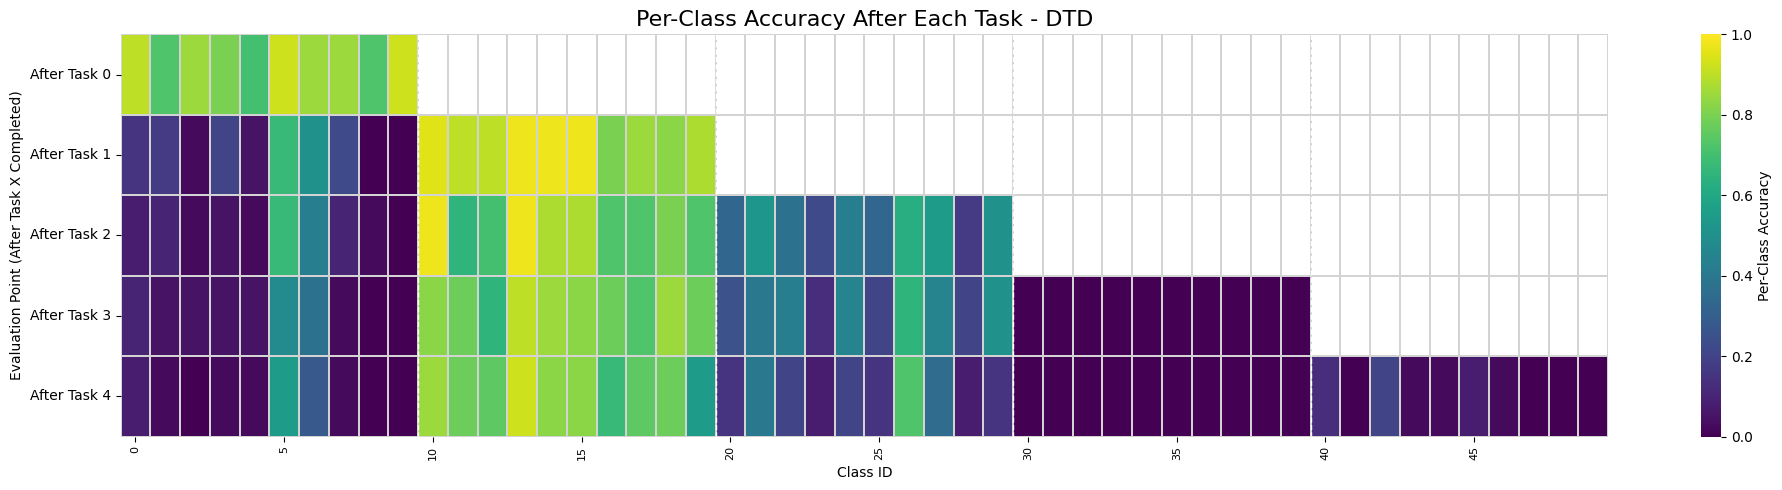

In [20]:
# texture dataset
accuracy_file_path = 'replay-ewc-coarse-grained-1M/accuracies.txt' # Make sure this file exists
num_total_classes = 50
num_classes_per_task = 10

viz_acc_drops(accuracy_file_path, num_total_classes, num_classes_per_task, 'DTD')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

def viz_forgetting_measure(filepath, dataset):
  """
  Forgetting for a previous task i after learning task t is:
  max_accuracy(task i) - current_accuracy(task i).
  The average forgetting after task t is the average of this
  value across all tasks i < t.
  """
  data = []
  with open(filepath, 'r') as f:
      header = next(f) # Read header
      for line in f:
          parts = line.strip().split(',', 2) # Split only twice
          if len(parts) == 3:
              task = int(parts[0])
              overall_acc = float(parts[1])
              # Safely parse the string representation of the list
              per_class_str = parts[2]
              per_class_list = ast.literal_eval(per_class_str)
              data.append({
                  'Task': task,
                  'Overall Accuracy': overall_acc,
                  'Per-Class Accuracy': per_class_list
              })

  df = pd.DataFrame(data)
  # --- Determine classes per task ---
  num_tasks = len(df)
  classes_per_task = []
  cumulative_classes = 0
  class_indices_per_task = {} # Dictionary to store class indices for each task
  for i in range(num_tasks):
      current_total_classes = len(df.loc[i, 'Per-Class Accuracy'])
      num_new_classes = current_total_classes - cumulative_classes
      classes_per_task.append(num_new_classes)
      task_class_indices = list(range(cumulative_classes, current_total_classes))
      class_indices_per_task[i] = task_class_indices
      cumulative_classes = current_total_classes

  print(f"Detected {num_tasks} tasks.")
  print(f"Classes introduced per task: {classes_per_task}")
  print(f"Class indices per task: {class_indices_per_task}")

  # --- Calculate peak accuracy for each task ---
  # (Average accuracy on its classes right after it was learned)
  peak_task_accuracies = {}
  for i in range(num_tasks):
      task_class_indices = class_indices_per_task.get(i, [])
      # Get accuracies evaluated right after task i
      accuracies_at_eval_i = df.loc[i, 'Per-Class Accuracy']
      # Extract accuracies ONLY for classes belonging to task i
      task_i_class_accuracies = [accuracies_at_eval_i[idx] for idx in task_class_indices]
      peak_task_accuracies[i] = np.mean(task_i_class_accuracies)

  print(f"Peak average accuracy per task (Acc(i,i)): {peak_task_accuracies}")

  # --- Calculate Average Forgetting ---
  average_forgetting = []
  evaluation_points = [] # Tasks after which forgetting is measured (1 to T)

  for t in range(1, num_tasks): # Evaluate forgetting AFTER task t (t=1 to num_tasks-1)
      total_forgetting_at_t = 0.0
      num_previous_tasks_measured = 0

      # Get accuracies evaluated after task t
      accuracies_at_eval_t = df.loc[t, 'Per-Class Accuracy']

      for i in range(t): # Iterate through all tasks learned *before* t (i=0 to t-1)
        task_i_class_indices = class_indices_per_task.get(i, [])

        # Extract accuracies for task i's classes measured after task t
        task_i_accuracies_at_t = [accuracies_at_eval_t[idx] for idx in task_i_class_indices]
        current_acc_i_at_t = np.mean(task_i_accuracies_at_t)
        peak_acc_i = peak_task_accuracies.get(i, 0) # Get peak accuracy for task i

        # Calculate forgetting for task i
        forgetting_i_at_t = max(0, peak_acc_i - current_acc_i_at_t) # Ensure non-negative
        total_forgetting_at_t += forgetting_i_at_t
        num_previous_tasks_measured += 1

      avg_forgetting_t = total_forgetting_at_t / num_previous_tasks_measured
      average_forgetting.append(avg_forgetting_t)
      evaluation_points.append(t) # Record the task number after which this avg forgetting was calculated
  print(f"\nAverage Forgetting after each task {evaluation_points}: {average_forgetting}")

  # --- Plotting ---
  plt.figure(figsize=(8, 5))
  plt.plot(evaluation_points, average_forgetting, marker='o', linestyle='-')
  plt.xlabel("Task Number Completed (Evaluation Point)")
  plt.ylabel("Average Forgetting")
  plt.title(f"Average Forgetting vs. Number of Tasks Completed - {dataset}")
  plt.xticks(evaluation_points) # Ensure ticks are at the actual task numbers
  plt.grid(True, linestyle='--', alpha=0.6)
  plt.ylim(bottom=0) # Forgetting cannot be negative
  plt.show()

In [ ]:
viz_forgetting_measure('replay-ewc-coarse-grained/accuracies.txt', 'DTD')